#Churn Model 
    - Predict user churn by training several models on user behavior
    - Use predicted probabilities to gauge likelihood of churn
    - Choose the best model based on the metric Recall
    - Use the best performing model to create a Profit Curve

##Problem
    The company is loosing user's subscription to their service, which is driving down profits. 
    
##Solution
    Identify the user features that best predict which users are the most likely to unsubscribe
    the the company's service and engage them with a speical offer with the intention that they
    continue the service. 

#Work Flow

###Clean Data
    - Drop irrelavent features
    
###Exploritory Data Analysis
    - Rescale features
    - Balance Classes

###Feature Importance
    - Use Random Forest to identify most predictive features
    
###Modeling
    - Train Logistic Regression, SVM, and Gradient Boosting 

###Profit Curve
    - Identify lowest cost solution to maintain the greatest number of users that are at risk of churning

####Import revelent packages

In [3]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import time
%matplotlib inline

####Train_Test_Predict 
    - A class that performs routine Machine Learning model training, testing, and predicting
      in order to validate hyperparameters

In [4]:
# %load ~/Documents/scripts/machine_learning.py
from __future__ import division 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import KFold, train_test_split

class Train_Test_Predict(object):
    

    def __init__(self,model,X, y, confusion = False, average = "weighted"):
        self.model = model
        # Train and development data sets for hyperparameter tuning 
        self.Xtrain,\
        self.Xtest,\
        self.ytrain,\
        self.ytest = train_test_split(X,y,test_size = 0.20)
        # Predicted response for test/development set
        self.ypred = None
        # Stores metrics in KFold 
        self.acc = []
        self.pre = []
        self.rec = []
        self.confusion = confusion
        self.confusion_matrix = None
        self.average_type = average

    def _train_develop_model(self):

        kf = KFold(n = self.Xtrain.shape[0],\
                   n_folds = 10,\
                   random_state = 41,\
                   shuffle = True)

        for train_index, test_index in kf:
            X_train, X_test = self.Xtrain[train_index], self.Xtrain[test_index]
            y_train, y_test = self.ytrain[train_index], self.ytrain[test_index]

            self.model.fit(X_train,y_train)
            
            self.ypred = self.model.predict(X_test)
            
            self._apply_metrics(y_test)
        print "NOTE: average = {} for precison and recall.\n".format(self.average_type)
    
    def _apply_metrics(self, y):
        self.acc.append(accuracy_score(y,self.ypred))
        self.pre.append(precision_score(y,self.ypred, average = self.average_type))
        self.rec.append(recall_score(y,self.ypred, average = self.average_type))      
    
    def _print_trainSet_results(self):
        print self.model.__class__.__name__ + "  Training"
        print "Accuracy:  {:.3}".format(np.mean(self.acc))
        print "Precision: {:.3}".format(np.mean(self.pre))
        print "Recall:    {:.3} \n".format(np.mean(self.rec))

    def _print_testSet_results(self):
        print self.model.__class__.__name__ + "  Development"
        print "Accuracy:  {:.3}".format(accuracy_score(self.ytest,self.ypred))
        print "Precision: {:.3}".format(precision_score(self.ytest,self.ypred, average = self.average_type))
        print "Recall:    {:.3}".format(recall_score(self.ytest,self.ypred,average = self.average_type))


    def fit_predict_model(self):

        self._train_develop_model()

        self.ypred = self.model.predict(self.Xtest)

        self._print_trainSet_results()

        self._print_testSet_results()
                
        if self.confusion == True:
            self.confusion_matrix = confusion_matrix(self.ytest,self.ypred)
            print "\nConfusion Matrix"
            print self.confusion_matrix
            print "\nsklearn orientation"
            print "| TN | FP |"
            print "| FN | TP |"                 
                

###Cleaning Data

In [5]:
true = ["yes",
        "True",
        "True."]

false = ["no",
         "False",
         "False."]

In [6]:
df = pd.read_csv("~/DSCI6003-student/week4/exercise/data/churn.csv",
                 true_values = true, 
                 false_values = false)

In [7]:
drop_col = ["State",
            "Account Length",
            "Area Code",
            "Phone"]

df.drop(drop_col, 
        axis = 1, 
        inplace = True)

In [8]:
df.rename(columns={'Churn?':'Churn'}, 
          inplace=True)

###Exploratory Data Analysis
    - Rescale features
    - Balance Classes

In [9]:
df.head()

,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [10]:
# Need to rescale columns 
# The means and std vary greatly from feature to feature
df.describe()

,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
count,3333,3333,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333
mean,0.09690969,0.2766277,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.1449145
std,0.2958791,0.4473979,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.3520674
min,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,False
25%,0,0,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0
50%,0,0,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0
75%,0,1,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0
max,True,True,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,True


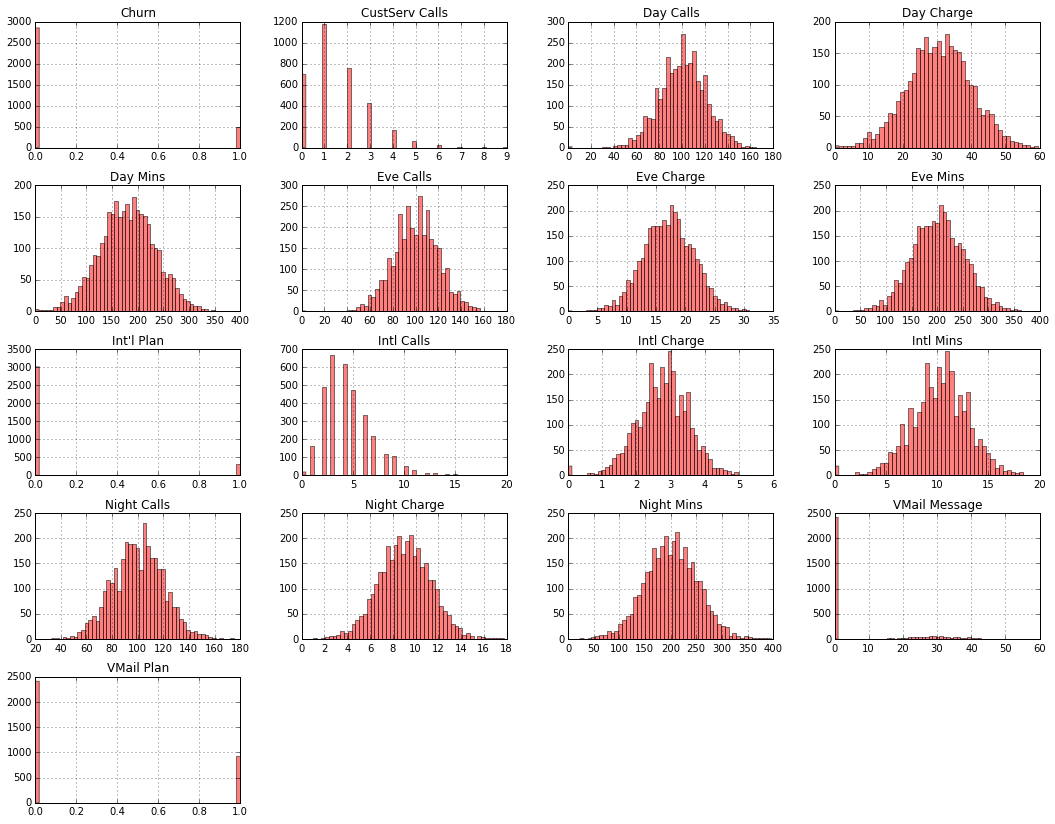

In [11]:
# Dist of features - before rescaling
df.hist(color='r', alpha=0.5, bins=50, figsize=(18, 14));

####Rescale Features

In [12]:
# columns won't rescale unless dtyp = "float"
df2 = df[df.columns[2:-1]].astype(float)

In [13]:
# rescale columns to range (-1,1)
# Do not include columns with boolean values
df2[df.columns[2:-1]] = df2[df.columns[2:-1]].apply(lambda x: MinMaxScaler(feature_range=(-1,1)).fit_transform(x))

In [14]:
# Move columns with boolean values back into dataframe
df2[df.columns[0]] = df[df.columns[0]].values
df2[df.columns[1]] = df[df.columns[1]].values
df2[df.columns[-1]] = df[df.columns[-1]].values

In [15]:
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan,VMail Plan,Churn
0,-0.019608,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,False,True,False
1,0.019608,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,False,True,False
2,-1.000000,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,False,False,False
3,-1.000000,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,True,False,False
4,-1.000000,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,True,False,False


In [16]:
df2.describe()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan,VMail Plan,Churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333,3333,3333
mean,-0.682392,0.024944,0.217402,0.024893,0.105199,0.177815,0.105373,-0.044260,-0.054821,-0.043715,0.023729,-0.552055,0.023919,-0.652699,0.09690969,0.2766277,0.1449145
std,0.536799,0.310532,0.243262,0.310511,0.278877,0.234384,0.278917,0.272049,0.275614,0.272071,0.279184,0.246121,0.279175,0.292331,0.2958791,0.4473979,0.3520674
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,False,False,False
25%,-1.000000,-0.180730,0.054545,-0.180751,-0.083860,0.023529,-0.083792,-0.226466,-0.239437,-0.225344,-0.150000,-0.700000,-0.148148,-0.777778,0,0,0
50%,-1.000000,0.022805,0.224242,0.022803,0.107506,0.176471,0.107732,-0.042496,-0.056338,-0.042439,0.030000,-0.600000,0.029630,-0.777778,0,0,0
75%,-0.215686,0.233751,0.381818,0.233736,0.293924,0.341176,0.294080,0.140936,0.126761,0.141662,0.210000,-0.400000,0.211111,-0.555556,0,1,0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True


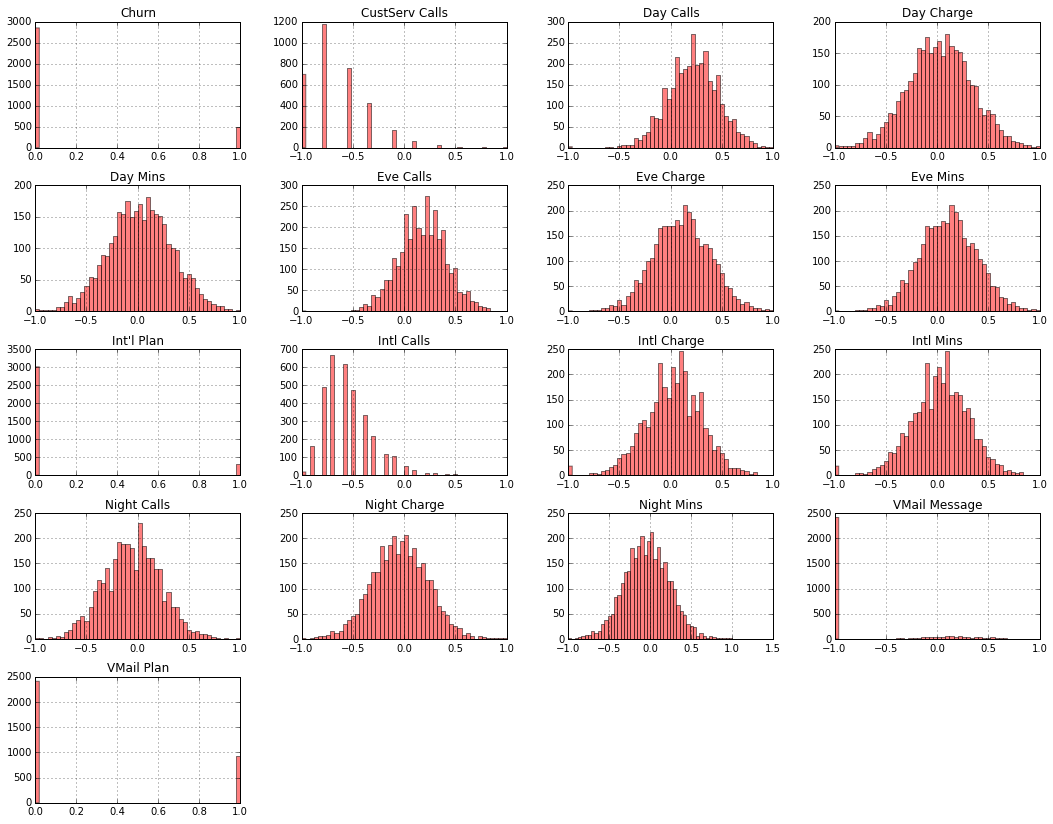

In [17]:
# Dist of features - after rescaling to (-1,1)
df2.hist(color='r', alpha=0.5, bins=50, figsize=(18, 14));

###Balance Classes

We will explore 3 approaches to balancing classes
    - Undersampling the majority class
    - Oversampling the minority class
    - SMOTE (Synthetic Minority Oversampling Technique)

#####Why are imbalanced classes a problem?

We are interested in a fairly high rate of correct detection of the minority class (churn)
and we are wiling to allow for a small error rate in the majority class (don't churn). However an imbalanced data set prevents a classifier from being properly trained. Without enough churn data points, the classifer will not be able to learn enough of the predictive indicators of churn. 

In [18]:
# Imbalanced Classes ! 
df.Churn.value_counts()

False    2850
True      483
dtype: int64

In [19]:
print "Accuracy {:.3}".format(2850 / (2850 + 483) * 100)

Accuracy 85.5


#####Metrics
Before classes are balanced, it is important to understand why the metrics Precision and Recall are chosen to measure the performance of a model and why accuracy alone is not enough. 

If we were to just assume that every user doesn't churn, then our accuracy would be 85.5% because the vast majority don't churn. But this tells us nothing about how well we can identify those users who actually do or do not churn, nor how often we are correct in stating that a user is likely to churn. 

#####Precison

when a classier $\textbf{predicts}$ an individual will churn, how often does the individual $\textbf{actually}$ churn?

#####Recall
Of those that do churn and do not churn, how many of them was my classifier able to correctly $\textbf{identify}$?

#### Confusion Matrix
We can get a better picture of our model but looking at the confusion matrix. We get the following four metrics:

* **True Positives (TP)**: Correct positive predictions
* **False Positives (FP)**: Incorrect positive predictions (false alarm)
* **True Negatives (TN)**: Correct negative predictions
* **False Negatives (FN)**: Incorrect negative predictions (a miss)

|            | Predicted Yes  | Predicted No   |
| ---------- | -------------- | -------------- |
| Actual Yes | True positive  | False negative |
| Actual No  | False positive | True negative  |


* **Precision**: A measure of how good your positive predictions are
    ```
    Precison = TP / (TP + FP)
             = TP / (predicted yes)
    ```
* **Recall**: A measure of how well you predict positive cases. Aka *sensitivity*.
    ```
    Recall = TP / (TP + FN) 
           = TP / (actual yes)
    ```

####Note:
    confusion matricies from train models throughout this notebook have sklearn orientation:
                            
                                    sklearn orientation
                                        | TN | FP |
                                        | FN | TP |

####For our data set

    FP = Predicted to churn, doesn't churn

    FN = Predicted to NOT churn, actually churns

In [20]:
# Warning: this approach can discard important observations
def undersample(X, y, majority_weight=.5):
    '''
    randomly discards observations from majority class
    so that output X, y have specified percentage of majority observations
    '''
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_majority = X[y==majority_class_label]
    y_majority = y[y==majority_class_label]
    maj_count = len(X_majority)
    min_count = len(X) - maj_count
    scaling_factor = (min_count/float(maj_count))*(majority_weight/(1-majority_weight))
    sample_indices = np.random.choice(xrange(maj_count), 
                                      size=round(maj_count*scaling_factor),
                                      replace=False)
    X_majority = X_majority[sample_indices]
    y_majority = y_majority[sample_indices]
    X = np.vstack((X_majority, X[y!=majority_class_label]))
    y = np.hstack((y_majority, y[y!=majority_class_label]))
    return X, y

In [21]:
# Warning: This approach can over fit to the data
def oversample(X, y, minority_weight=.5):
    '''
    duplicates observations from minority class
    so that output X, y have specified percentage of majority observations
    '''
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_minority = X[y!=majority_class_label]
    y_minority = y[y!=majority_class_label]
    min_count = len(X_minority)
    maj_count = len(X) - min_count
    scaling_factor = round((maj_count/float(min_count))*(minority_weight/(1-minority_weight)))
    # tile repeats the obs in X_minority by the scaling_factor
    X_minority = np.tile(X_minority, (scaling_factor, 1))
    y_minority = np.tile(y_minority, scaling_factor)
    X = np.vstack((X_minority, X[y==majority_class_label]))
    y = np.hstack((y_minority, y[y==majority_class_label]))
    return X, y

In [22]:
def smote(X, y, minority_weight=.5):
    '''
    generates new observations in minority class
    so that output X, y have specified percentage of majority observations
    '''
    # compute number of new examples required
    # True = 1, False = 0 
    # If True is majority (>=.50) Then round(class_ratio) = 1.0 
    # Else if False is majoirty (< .50) Then round(class_ratio) = 0.0
    # For walk through, let majority class be False = 0
    class_ratio = y.sum()/float(len(y))
    # majority_class_label = 0.0
    majority_class_label = round(class_ratio)
    
    # X_minority holds all obs that correspond to the True label (minority class)
    X_minority = X[y!=majority_class_label]
    # y_minority holds all True values (minority class)
    y_minority = y[y!=majority_class_label]
    min_count = len(X_minority)
    maj_count = len(X) - min_count
    # scaling factor, for minority_weight = 0.5, reduces to Maj_count = SF * Min_count
    # the SF is the ratio between theh classes, muliplying by this will balance them
    scaling_factor = (maj_count/float(min_count))*(minority_weight/(1-minority_weight))
    # generate new_obs_targets so that the minority class will be balance with the majority class
    new_observations_target = round(scaling_factor*min_count) - min_count

    # train KNN
    knn_model = KNeighborsClassifier(n_neighbors=int(round(len(X_minority)**.5)))
    knn_model.fit(X_minority, y_minority)
    if new_observations_target < len(X_minority):
        sample_indices = np.random.choice(xrange(X_minority), 
                                          size=new_observations_target,
                                          replace=False)
        smote_samples = X_minority[sample_indices]
    else:
        smote_samples = X_minority
    neighbors = knn_model.kneighbors(smote_samples)[1]
    
    # generate new samples
    new_observations = np.empty((0,X.shape[1]))
    while len(new_observations) < new_observations_target:
        index = len(new_observations) % len(smote_samples)
        neighbor_index = np.random.choice(neighbors[index])
        neighbor = smote_samples[neighbor_index]
        x = X_minority[index]
        new_x = x + (neighbor - x)*np.random.random(size=X_minority.shape[1])
        new_observations = np.vstack((new_observations, new_x))
    minority_class_label = (majority_class_label + 1) % 2
    X = np.vstack((X, new_observations))
    y = np.hstack((y, np.array([minority_class_label]*len(new_observations))))
    
    return X, y

In [23]:
# target values: churn/not churn --> true/false
y = df2.Churn.values
# feature data
X = df2[df2.columns[:-1]].values

####Unbalanced

First, let's train the unbalanced data on a Random Forest Classifier (RFC)

In [24]:
model = Train_Test_Predict(RandomForestClassifier(), 
                           X,
                           y, 
                           confusion = True,
                           average = "binary")

In [25]:
model.fit_predict_model()

NOTE: average = binary for precison and recall.

RandomForestClassifier  Training
Accuracy:  0.946
Precision: 0.903
Recall:    0.687 

RandomForestClassifier  Development
Accuracy:  0.939
Precision: 0.958
Recall:    0.645

Confusion Matrix
[[557   3]
 [ 38  69]]

sklearn orientation
| TN | FP |
| FN | TP |


We see that the RFC scores well on Accuracy and Precision on the imbalanced data set. However, the metric Recall performs very poorly. About 60% of the time, the RFC is able to correctly identify which users actually do and do not churn. 

####Undersampling

In [26]:
X_undersample, y_undersample = undersample(X,y)

In [27]:
model2 = Train_Test_Predict(RandomForestClassifier(), 
                           X_undersample,
                           y_undersample, 
                           confusion = True,
                           average = "binary")

In [28]:
model2.fit_predict_model()

NOTE: average = binary for precison and recall.

RandomForestClassifier  Training
Accuracy:  0.847
Precision: 0.889
Recall:    0.795 

RandomForestClassifier  Development
Accuracy:  0.892
Precision: 0.903
Recall:    0.894

Confusion Matrix
[[80 10]
 [11 93]]

sklearn orientation
| TN | FP |
| FN | TP |


By undersampling the majority class, we can see that the model scores worst on both Precision and Recall metrics. Comparing these resutls with the unbalanced set, we are lead to conclude that undersampling is dropping out important obserations.

####Oversampling

In [29]:
X_oversampling, y_oversampling = oversample(X,y)

In [30]:
model3 = Train_Test_Predict(RandomForestClassifier(), 
                           X_oversampling,
                           y_oversampling, 
                           confusion = True,
                           average = "binary")

In [31]:
model3.fit_predict_model()

NOTE: average = binary for precison and recall.

RandomForestClassifier  Training
Accuracy:  0.99
Precision: 0.981
Recall:    0.999 

RandomForestClassifier  Development
Accuracy:  0.993
Precision: 0.986
Recall:    1.0

Confusion Matrix
[[565   8]
 [  0 577]]

sklearn orientation
| TN | FP |
| FN | TP |


By oversampling the minority class (users who churn), the models has been able to score extreamly (suspiciously) well on all three metircs. However, these results may be misleading. By oversampling on the minority class (having multiple duplicates of users who churn) we are very likely overfitting to this particular data set. 

####SMOTE (Synthetic Minority Oversampling Technique)

In [32]:
X_smote, y_smote = smote(X,y)

In [33]:
model4 = Train_Test_Predict(RandomForestClassifier(), 
                           X_smote,
                           y_smote, 
                           confusion = True,
                           average = "binary")

In [34]:
model4.fit_predict_model()

NOTE: average = binary for precison and recall.

RandomForestClassifier  Training
Accuracy:  0.927
Precision: 0.954
Recall:    0.898 

RandomForestClassifier  Development
Accuracy:  0.922
Precision: 0.949
Recall:    0.889

Confusion Matrix
[[552  27]
 [ 62 499]]

sklearn orientation
| TN | FP |
| FN | TP |


SMOTE performs better than the imbalanced data set and the undersampling cases, however it does not perform as well as the oversamplingly case. Nevertheless, we will balanced the data set by using the SMOTE approach. 

SMOTE uses the KNearestNeighbors classifier to generate new users who churn. However, unlike the Oversampling approach, these new users will not be identitical replications of exisitng users. These users will have very similar features as existing users who churn (as one might expect), however with some slight random variation to minimize overfitting to the data set. This seems like the right comprimise between high performance and overfitting. 

##Goals
1. Use Random Forest for Feature Importance
2. Model Data with 3 different classifers 
3. Assign a churn probability to each costumor
4. Plot Predicted Probability Vs. Actual Outcomes
5. Compare models 
6. Create Profit Curves with best performing model

##Feature Importance

We will explore feature importance based on model4, which was trained using SMOTE

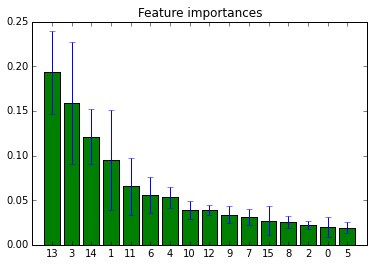

In [35]:
feats = model4.model.feature_importances_
## rfc3.estimators_ --> list of Decision Tree Classifer Instances 
std = np.std([tree.feature_importances_ for tree in model4.model.estimators_],
             axis=0)
indices = np.argsort(feats)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(feats)), feats[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(16), indices)
plt.xlim([-1, 16])
plt.ylim([0,.25])
plt.show()

In [36]:
print "Features ranked in order of importance\n"
for ind in indices:
    print df.columns[ind]

Features ranked in order of importance

Intl Calls
Day Mins
Intl Charge
VMail Plan
Night Charge
Eve Mins
Day Calls
Night Calls
Intl Mins
Night Mins
Eve Calls
CustServ Calls
Eve Charge
VMail Message
Int'l Plan
Day Charge


#####The performance of SMOTE on the entire data set

    RandomForestClassifier  Development
    Accuracy:  0.932
    Precision: 0.961
    Recall:    0.895

    Confusion Matrix
    [[566  20]
     [ 58 496]]


####Fit model on 12 highest ranked features

In [37]:
X_top_features = df2[indices[0:12]].values

In [38]:
X_smote2, y_smote2 = smote(X_top_features,y)

In [39]:
model5 = Train_Test_Predict(RandomForestClassifier(),
                            X_smote2, 
                            y_smote2,
                            confusion = True,
                            average = "binary")

In [40]:
model5.fit_predict_model()

NOTE: average = binary for precison and recall.

RandomForestClassifier  Training
Accuracy:  0.938
Precision: 0.966
Recall:    0.906 

RandomForestClassifier  Development
Accuracy:  0.929
Precision: 0.962
Recall:    0.898

Confusion Matrix
[[532  21]
 [ 60 527]]

sklearn orientation
| TN | FP |
| FN | TP |


####Results on Feature Importance

Comparing the metrics between traning RFC on the full feature set and on the first 12 most important features, we see that we get about the same performance from the model. The values will fluctuate a little each time the model is run, however training on the 12 highest ranking features will almost always perform just as well, or better, as the full feature set. 

Moving forward we will drop the lowest 4 ranked features: VMail Message, Day Charge, Eve Charge, CustServ Calls. By varying the number of ranked features that are included in the modeling, it was observed that once the lower 4 features where included into the set of features, the model's performance decreased. This indicates that the lower 4 features contain more noise than signal - they are not predictive of churn.  

#Modeling

    - Train models on SMOTE data
    - Test models by predicting on unbalanced data 

We will use 3 different models to predict the probabiity of churn, plot the distribution of predicted probabilities, and discuss the results
    - Random Forest
    - Gradient Boosting
    - SVM

For Random Forest, we will use the default turning of the parameters since they perform just as well, or better, then parameters tuned from a grid search. 

In [259]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X_top_features,y, test_size = 0.20)

In [261]:
X_smote_train, y_smote_train = smote(Xtrain,ytrain)

In [262]:
model6 = Train_Test_Predict(RandomForestClassifier(),
                            X_smote_train, 
                            y_smote_train,
                            confusion = True,
                            average = "binary")

In [263]:
model6.fit_predict_model()

NOTE: average = binary for precison and recall.

RandomForestClassifier  Training
Accuracy:  0.936
Precision: 0.965
Recall:    0.904 

RandomForestClassifier  Development
Accuracy:  0.932
Precision: 0.965
Recall:    0.899

Confusion Matrix
[[432  15]
 [ 47 417]]

sklearn orientation
| TN | FP |
| FN | TP |


In [267]:
rfc_fitted = model6.model

In [268]:
ypred = rfc_fitted.predict(Xtest)

Results from testing the model on the unbalanced data 

These are the definitive metrics that inform us about how well this classifier will perform.

In [269]:
print "accuracy  {:.3}".format(accuracy_score(ytest, ypred))
print "precision {:.3}".format(precision_score(ytest, ypred))
print "recall    {:.3}".format(recall_score(ytest, ypred))

accuracy  0.936
precision 0.78
recall    0.755


In [271]:
# save probabilities for yes churn
churns_rfc = rfc_fitted.predict_proba(Xtest)[:,1]

In [272]:
users_rfc = np.arange(1,churns_rfc.size +1,1)

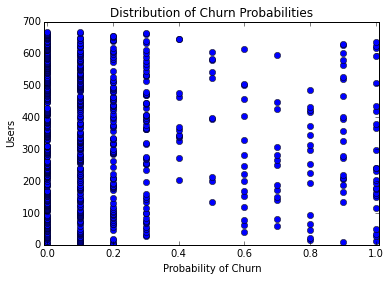

In [273]:
plt.plot(churns_rfc,users_rfc, "o");
plt.xlim([-0.01, 1.01]);
plt.title("Distribution of Churn Probabilities");
plt.xlabel("Probability of Churn");
plt.ylabel("Users");

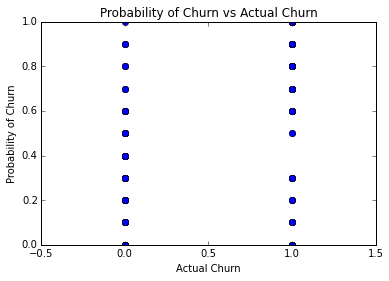

In [275]:
plt.plot(ytest,churns_rfc ,"o");
plt.xlim([-0.5, 1.5]);
plt.title("Probability of Churn vs Actual Churn ");
plt.ylabel("Probability of Churn");
plt.xlabel("Actual Churn");

As a visual aid, we can interpret the *Probability of Churn vs Actual Churn* plot as a confusion matrix with the follow orientation 


                                    | FP | TP |
                                    | TN | FN |
                                    

The *Distribution of Churn Probabilities* plot shows us that the RFC probabilities are spread out. There are a lot of low probabilities for churn below 20%. There are many probabilities in the "uncertian" region between 40% and 60%. 

The *Probability of Churn vs Actual Churn* plot shows us that the predicted probabilities for churn are evenly spread out between predicting churn and being right and predicting churn and being wrong. This plot tells us that RFC's probabilites for churn are not the most reliable.

###GradientBoosting

Optimized Hyper-Parameters

    (F1 = 0.96734218047336817,
      {'learning_rate': 0.1,
       'max_depth': 5,
       'max_features': 6,
       'min_samples_leaf': 2,
       'min_samples_split': 4})

In [251]:
# optimized hyperparameters
gb = GradientBoostingClassifier(n_estimators = 1000,
                                learning_rate = 0.1,
                                max_depth = 5,
                                max_features = 6,
                                min_samples_leaf = 2,
                                min_samples_split = 4,
                                random_state = 41)

In [276]:
model7 = Train_Test_Predict(gb, 
                         X_smote_train, # top 12 ranked features
                         y_smote_train, 
                         confusion=True,
                         average = "binary")

In [277]:
model7.fit_predict_model()

NOTE: average = binary for precison and recall.

GradientBoostingClassifier  Training
Accuracy:  0.974
Precision: 0.983
Recall:    0.964 

GradientBoostingClassifier  Development
Accuracy:  0.976
Precision: 0.98
Recall:    0.972

Confusion Matrix
[[444   9]
 [ 13 445]]

sklearn orientation
| TN | FP |
| FN | TP |


In [278]:
gdb_fitted_model = model7.model

In [279]:
ypred2 = gdb_fitted_model.predict(Xtest)

Results from testing the model on the unbalanced data

These are the definitive metrics that inform us about how well this classifier will perform.

In [280]:
print "accuracy  {:.3}".format(accuracy_score(ytest, ypred2))
print "precision {:.3}".format(precision_score(ytest, ypred2))
print "recall    {:.3}".format(recall_score(ytest, ypred2))

accuracy  0.948
precision 0.864
recall    0.745


In [281]:
# col1 --> False, no churn
# col2 --> True, yes churn
gdb_fitted_model.predict_proba(Xtest)[0:5,:]

array([[  9.99937248e-01,   6.27523749e-05],
       [  9.99851500e-01,   1.48499711e-04],
       [  9.99852554e-01,   1.47445556e-04],
       [  9.99983143e-01,   1.68570875e-05],
       [  9.99993947e-01,   6.05280637e-06]])

In [282]:
# save probabilities for yes churn
churns_gdb = gdb_fitted_model.predict_proba(Xtest)[:,1]

In [283]:
users = np.arange(1,churns_gdb.size +1,1)

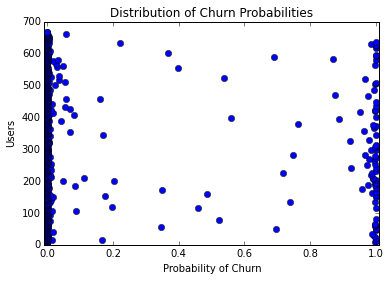

In [284]:
plt.plot(churns_gdb,users, "o");
plt.xlim([-0.01, 1.01]);
plt.title("Distribution of Churn Probabilities");
plt.xlabel("Probability of Churn");
plt.ylabel("Users");

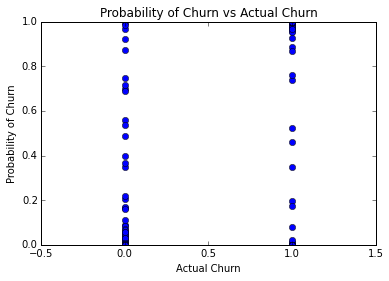

In [285]:
plt.plot(ytest,churns_gdb ,"o");
plt.xlim([-0.5, 1.5]);
plt.title("Probability of Churn vs Actual Churn ");
plt.ylabel("Probability of Churn");
plt.xlabel("Actual Churn");

As a visual aid, we can interpret the *Probability of Churn vs Actual Churn* plot as a confusion matrix with the follow orientation 


                                    | FP | TP |
                                    | TN | FN |
                                    


The 1st graph shows that Gradient Boosting Classifer assignes strong probabilities to a user's likelihood of churning or not churning. The 2nd graph shows that the model's probabilities are meaningful. 

At the top of the right column (1.0 means Churn), a high probability of churning correctly predicts churn (True Positives)

At the bottom of the left column (0.0 means No Churn), low (below 20%) probabilities are assigned to many user's likelihood of churning--another way of saying the same thing is to say a HIGH probability of NOT churning is assigned--these users in fact do not churn (True Negatives). These are great resutls.

The problem is at the bottom of the right column, low probabilities are assigned to churning--another way of saying that is a HIGH probability of NOT churning is assinged--yet these users do in fact churn. These users are the False Negatives: user's that are predicted to NOT churn but actually do chrun. These users are our biggest concern. Fortunately, we can see from the confusion matrix below that these users are relatively low in count.  

Also notice at the top of the left column. These users are the False Positives: user's that are predicted to churn but do in fact do NOT churn. These users are of much less concern to the business.

Also the 2nd graph shows that GBC predicts very few probabilities in the "uncertainty" region between 40% and 60%. 

In [305]:
print model7.confusion_matrix

[[444   9]
 [ 13 445]]


                        confusion matrix has sklearn orientation:
                                    | TN | FP |
                                    | FN | TP |

###SVM

Optimized Hyper-Parameters

     (F1 = 0.91093502317158193, {'C': 100.0, 'gamma': 1.0, 'kernel': 'poly'})

In [287]:
svc = SVC(C = 100.0, 
          gamma = 1.0, 
          kernel = "poly",
         probability = True)

In [288]:
model8 = Train_Test_Predict(svc, 
                         X_smote_train, # top 12 ranked features
                         y_smote_train, 
                         confusion=True,
                         average = "binary")

In [289]:
model8.fit_predict_model()

NOTE: average = binary for precison and recall.

SVC  Training
Accuracy:  0.906
Precision: 0.943
Recall:    0.864 

SVC  Development
Accuracy:  0.901
Precision: 0.946
Recall:    0.85

Confusion Matrix
[[435  22]
 [ 68 386]]

sklearn orientation
| TN | FP |
| FN | TP |


In [293]:
svc_fitted_model = model8.model

In [294]:
ypred3 = svc_fitted_model.predict(Xtest)

Results from testing the model on the unbalanced data

These are the definitive metrics that inform us about how well this classifier will perform.

In [295]:
print "accuracy  {:.3}".format(accuracy_score(ytest, ypred3))
print "precision {:.3}".format(precision_score(ytest, ypred3))
print "recall    {:.3}".format(recall_score(ytest, ypred3))

accuracy  0.921
precision 0.73
recall    0.691


In [296]:
# save probabilities for yes churn
churns_svc = svc_fitted_model.predict_proba(Xtest)[:,1]

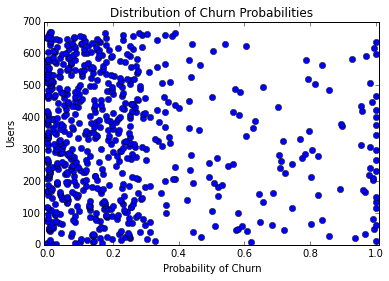

In [297]:
plt.plot(churns_svc,users, "o");
plt.xlim([-0.01, 1.01]);
plt.title("Distribution of Churn Probabilities");
plt.xlabel("Probability of Churn");
plt.ylabel("Users");

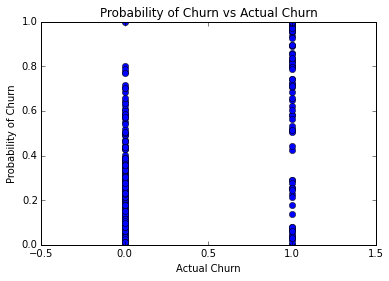

In [298]:
plt.plot(ytest,churns_svc ,"o");
plt.xlim([-0.5, 1.5]);
plt.title("Probability of Churn vs Actual Churn");
plt.ylabel("Probability of Churn");
plt.xlabel("Actual Churn");

As a visual aid, we can interpret the *Probability of Churn vs Actual Churn* plot as a confusion matrix with the follow orientation 


                                    | FP | TP |
                                    | TN | FN |
                                    

The *Distribution of Churn Probabiliteis* plot shows us that SVM predicts low probabilities of churns for the vast majorty of users. It makes very little strong predictions for churn -- few probabilities above 80%. Most importantly, the 1st plot shows that SVM has many probabilites in the "uncertian" region between 40% and 60%. This is not a good sign.

The *Probability of Churn vs Actual Churn* plot has discouraging results. We can see that SVM's has only a few predicted probabilities in the False Positive region, this is good. However, many probabilities exist in the False Negative region -- which is the error that we are most interested in minimizing. 

###Results on Modeling

Let's review the metrics on all 3 models

#####Random Forest

In [299]:
print "accuracy  {:.3}".format(accuracy_score(ytest, ypred))
print "precision {:.3}".format(precision_score(ytest, ypred))
print "recall    {:.3}".format(recall_score(ytest, ypred))

accuracy  0.936
precision 0.78
recall    0.755


#####Gradient Boosting

In [300]:
print "accuracy  {:.3}".format(accuracy_score(ytest, ypred2))
print "precision {:.3}".format(precision_score(ytest, ypred2))
print "recall    {:.3}".format(recall_score(ytest, ypred2))

accuracy  0.948
precision 0.864
recall    0.745


####SVM

In [301]:
print "accuracy  {:.3}".format(accuracy_score(ytest, ypred3))
print "precision {:.3}".format(precision_score(ytest, ypred3))
print "recall    {:.3}".format(recall_score(ytest, ypred3))

accuracy  0.921
precision 0.73
recall    0.691


For our data set

    FP = Predicted to churn, doesn't churn

    FN = Predicted to NOT churn, actually churns


    Precison = TP / (TP + FP)
             = TP / (predicted yes)

    Recall = TP / (TP + FN) 
           = TP / (actual yes)

Remember -- we are interested in a fairly high rate of correct detection of the minority class (churn) and we are wiling to allow for a small error rate in the majority class (don't churn)

In other words, we are willing to classify non-churners as churners in order to catch as many true churners as possible. In order to do this, we need to minimize False Negatives (FN). Which in turn means we need to prioritze recall over precision. 

Looking at the test results, we see that Gradient Boosting and Random Forest have the highest recall. Also, Gradient Boosting has the highest precision, so we will choose GB to predict churn and to produce our profit curve.  

#Profit Curve!

In order to apply our findings of predictive probabilities, we will create a profit curve. The first step to creating a profit curve is to construct a cost benefit matrix.

                    Features that are most predictive of Churn

                                    Intl Calls
                                    Day Mins

Let's say that we want to incentivize users that are at risk of churning to stay with a 5 dollar coupon good towards the purchase of 100 dollars worth of International Call minutes and Day time minutes. Remember that International Calls (Intl Calls) and Day time minutes (Day Mins) were ranked as the two most important features that predict churn by the Random Forest classifier. Also let's say that the cost of mailing the coupon is  $5. 

Case 1: If users are predicted to stay, do not mail coupon.

Case2:  If users are predicted to leave, then mail coupon and consider 2 sub-cases.

    Sub-case1: User buys, then the business makes a $90 profit and retains a user.

    Sub-case2: user doesn't buy, then the business loses $5 and a user. 
   

                      
                                     will buy  won't buy
                             leave   | $90    | -$5   |
                             stay    | $0     |  $0   |
                         
Rewriting this in a confusion matrix:

                                         Actual
                                     No churn  churn
            Prediction   No churn    |  $0    |  $0  |
                            churn    |  -$5   |  $90 |                        
                         
                         
                        confusion matrix has sklearn orientation:
                                     | TN | FP |
                                     | FN | TP |                         

In [303]:
# cost benefit of mailing $5 coupon (good towards a $100 purchase) at a cost of $5 mailing fee
cb = np.array([[0,0],[-5,90]])
cb

array([[ 0,  0],
       [-5, 90]])

In [158]:
def confusion_rates(cm):
    '''
    INPUT:  confusion_matrix 2-by-2 array must have sklearn orientation:
            | TN | FP |
            | FN | TP |
    OUTPUT: confusion_rates 2-by-2 array will have orientation:
            |TPR | FPR|
            |FNR | TNR|
    '''
    # TPR = TP / ( TP + FN )
    TPR = cm[1][1] / ( cm[1][1] + cm[1][0] )
    # FPR = FP / ( FP + TN ) 
    FPR = cm[0][1] / ( cm[0][1] + cm[0][0])
    # FNR = FN /  (FN + TP)
    FNR = cm[1][0] / ( cm[1][0] + cm[1][1])
    # TNR = TN / (TN + FP) 
    TNR = cm[0][0] / ( cm[0][0] + cm[0][1])
    
    return np.array([[TPR, FPR],[FNR, TNR]])

In [159]:
def profit(cb,cr, p_true, p_false):
    '''
    INPUT:  confusion_matrix 2-by-2 array must have sklearn orientation:
            | TN | FP |
            | FN | TP |
            confusion_rates 2-by-2 array will have orientation:
            |TPR | FPR|
            |FNR | TNR|
            p_true: prior probability of true classification (float)
            p_false: prior probability of false classification (float)
    OUTPUT: Profit values 1-dim array
    '''
    # cost/benefit values
    TP = cb[1][1]
    FP = cb[0][1]
    FN = cb[1][0]
    TN = cb[0][0]
    # rates
    TPR = cr[0][0]
    FPR = cr[0][1]
    FNR = cr[1][0]
    TNR = cr[1][1]

    return  p_true * ( TP*TPR + FN*FNR ) + p_false * ( FP*FPR + TN*TNR )    

In [202]:
def get_sorted_probs(model,Xtrain,Xtest,ytrain,ytest):
    # Build the model on the training set
    model.fit(Xtrain,ytrain)
    # Get the predict probabilities for the test set
    pred_prob = model.predict_proba(Xtest)
    # seperate prob true and prob false
    P_false_churn = pred_prob.T[0] # no churn
    P_true_churn  = pred_prob.T[1] # yes churn
    # Sort probs indices
    false_sort = np.argsort(P_false_churn)
    true_sort = np.argsort(P_true_churn)
    # Sort probs for looping through threshold
    P_false_churn_sort = P_false_churn[false_sort]
    P_true_churn_sort = P_true_churn[true_sort]
    return P_false_churn_sort, P_false_churn_sort

In [203]:
def predict_churn_alphas(P_false_sorted):
    # loop through threshold values
    # predict churn/no churn based on if prob is above or below threshold
    pred_churn_alphas = []
    alphas = []
    for alpha in P_false_sorted: # no churn
        pred_churn_alpha = []
        alphas.append(alpha)
        for prob in P_false_sorted:
            if prob >= alpha:
                pred_churn_alpha.append(True) # yes churn
            else:
                pred_churn_alpha.append(False) # no churn
        pred_churn_alphas.append(pred_churn_alpha) # list of probs for each alpha
    return pred_churn_alphas,alphas

In [207]:
def profit_curve(Xtrain,Xtest,ytrain, ytest,CB,*models):
    for model in models:
        
        P_false_sorted, P_true_sorted = get_sorted_probs(model,Xtrain,Xtest,ytrain,ytest)
    
        pred_churn_alphas, alpha_lst = predict_churn_alphas(P_false_sorted)
        # calculate confusion matrix for every alpha
        profit_values = []
        percent_pos_pop = []
        
        for pred, p_true,p_false in zip(pred_churn_alphas,P_true_sorted,P_false_sorted):
            # calcualte confusion matrix for every alpha
            cm = confusion_matrix(ytest,pred)
            
            # calculate confusion rates for every alpha
            cr = confusion_rates(cm)

            # calculate percent of Positive Prediction population
            percent_pos_pop.append((cm[0][0] + cm[1][1])\
                                   / (cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])  * 100)

   
            # calculate profit for every alpha
            profit_values.append(profit(CB, cr,p_true,p_false))
        
        
        # plot profit curve
        plt.plot(percent_pos_pop,profit_values)
        plt.title("Proft Curve: "+ model.__class__.__name__)
        plt.xlabel("% of positive population")
        plt.ylabel("Profit")
        plt.show()
                         

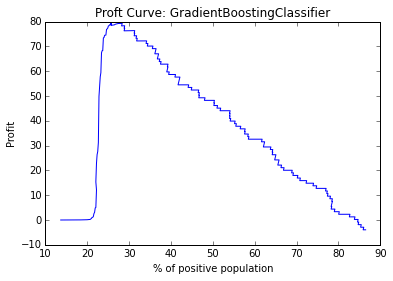

In [304]:
profit_curve(Xtrain2,Xtest2,ytrain2,ytest2,cb, gb)

###Results

First of all, the profit curve is telling us that the company can expect maximum profits from mailing $5 coupons if they mail those coupons to about 25% of the at risk for churn users. 

The earlier results from the *Probability of Churn vs Actual Churn* plots indicated that GB's probabilities are the most reliable. Therefore, we will mail a couple to 25% of users with the highest probability of churn, using the probabilites that GB gives us. 